In [1]:
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
import ntpath
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm_notebook as tqdm

from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"]="2"

class MelDataset(torch.utils.data.Dataset):
    def __init__(self, hp):
        wave_dir = '/home/scpark/hard/datasets/LJSpeech-1.1/wavs'
        wave_files = [join(wave_dir, f) for f in listdir(wave_dir) if isfile(join(wave_dir, f)) if 'wav' in f]
        wave_files.sort()
        print(len(wave_files))
        
        
        self.wave_files = wave_files
        self.sr = hp.sr
        self.n_mel = hp.n_mel
        self.hop_length = hp.hop_length
        self.length = hp.length
        self.fft_length = hp.fft_length
        self.ratio = hp.ratio
        self.fmax = hp.fmax
 
    def get_mel(self, audio):
        audio_norm = audio / MAX_WAV_VALUE
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = self.stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0)
        return melspec

    def __getitem__(self, index):
        wav, _ = librosa.core.load(self.wave_files[index], sr=self.sr)
        
        wav_length = int((self.length * self.hop_length) * 1.1)
        if len(wav) > wav_length:
            start_index = np.random.randint(0, len(wav)-wav_length)
            wav = wav[start_index:start_index+wav_length]
        
        wav = wav * np.random.uniform(0.98, 1.02)
        wav = librosa.effects.time_stretch(wav, np.random.uniform(0.98, 1.02))

        spec = librosa.core.stft(wav, n_fft=self.fft_length, hop_length=self.hop_length)
        spec = np.abs(spec)

        mel_basis = librosa.filters.mel(sr=self.sr, n_fft=self.fft_length, n_mels=self.n_mel, fmin=0, fmax=self.fmax)
        mel = mel_basis @ spec
        
        def dynamic_range_compression(x, lower_bound=1e-5):
            
            log_lower_bound = np.log(lower_bound)
            return (np.log(np.maximum(x, lower_bound)) - log_lower_bound) / -log_lower_bound

        mel = dynamic_range_compression(mel)
        mel = mel.T
        
        if len(mel) < self.length:
            mel = np.pad(mel, ((0, self.length - len(mel)), (0, 0)), 'constant')
        elif len(mel) > self.length:
            start_index = np.random.randint(0, len(mel)-self.length)
            mel = mel[start_index:start_index+self.length]
            
        return mel

    def __len__(self):
        return len(self.wave_files)
    
class Hparams:
    def __init__(self):
        '''Model Parameters'''
        self.n_coupling=16
        self.n_mel=2 ** 7
        self.h_dim=32
        self.ratio=3
        self.block_dim=8

        '''Data Parameters'''
        self.sr=22050
        self.length=2 ** 9
        self.fmax=8000
        self.fft_length=1024
        self.hop_length=256

hparams = Hparams()

trainset = MelDataset(hparams)
# =====END:   ADDED FOR DISTRIBUTED======
train_loader = DataLoader(trainset, num_workers=1, shuffle=True,
                          sampler=None,
                          batch_size=4,
                          pin_memory=False,
                          drop_last=True)


13100


### Flow2D

In [2]:
def squeeze2d(x):
    x1 = x[:, :, ::2, ::2]
    x2 = x[:, :, ::2, 1::2]
    x3 = x[:, :, 1::2, ::2]
    x4 = x[:, :, 1::2, 1::2]
    y = torch.cat([x1, x2, x3, x4], dim=1)
    
    return y

def unsqueeze2d(y):
    
    def sparse_pad(x, row_even=True, column_even=True):
        b, c, h, w = x.size()

        x = x.unsqueeze(4)
        x = F.pad(x, (0, 1) if column_even else (1, 0))
        x = x.reshape(b, c, h, 2*w)
        x = F.pad(x, (0, 2*w) if row_even else (2*w, 0))
        x = x.reshape(b, c, 2*h, 2*w)

        return x

    c = y.size(1) // 4 
    y1 = y[:, :c]
    y1 = sparse_pad(y1)
    y2 = y[:, c:2*c]
    y2 = sparse_pad(y2, column_even=False)
    y3 = y[:, 2*c:3*c]
    y3 = sparse_pad(y3, row_even=False)
    y4 = y[:, 3*c:]
    y4 = sparse_pad(y4, row_even=False, column_even=False)
    x = y1 + y2 + y3 + y4
    
    return x

def split(x):
    c = x.size(1) // 2
    y1 = x[:, :c]
    y2 = x[:, c:]
    
    return y1, y2
    
def merge(y1, y2):
    x = torch.cat([y1, y2], dim=1)
    
    return x

class Permutation2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        W = torch.eye(c)
        self.W = nn.Parameter(W)
        
    def forward(self, x):
        batch, channel, height, width = x.size()

        #log_det_W = torch.logdet(self.W)
        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = height * width * log_det_W
        y = F.conv2d(x, self.W[:, :, None, None])

        return y, dlog_det
        
    def inverse(self, y):
        W_inverse = self.W.inverse()
        x = F.conv2d(y, W_inverse[:, :, None, None])
        
        return x

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv = nn.utils.weight_norm(self.conv)
        self.act = nn.ReLU()
        
    def forward(self, x):
        y = self.conv(x)
        y = self.act(y)
        
        return y
    
class NonLinear2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = 256
        self.convs = nn.Sequential(Conv2d(in_channels=c, out_channels=h),
                                   Conv2d(in_channels=h, out_channels=h, kernel_size=1))
        self.last_conv = nn.Conv2d(in_channels=h, out_channels=c, kernel_size=3, stride=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x):
        # x: (B, C, H, W)
        y = self.convs(x)
        m = self.last_conv(y)
        
        return m
    
class Flow2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation2d(4*c)
        self.non_linear = NonLinear2d(2*c)
        
    def forward(self, x):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def inverse(self, y):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
        
class SqueezeAndFlows2d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow2d(c) for _ in range(num_flow)])
        
    def forward(self, x):
        y = squeeze2d(x)
        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y)
            log_det = dlog_det if log_det is None else log_det + dlog_det
            
        return y, log_det
    
    def inverse(self, y):
        x = y
        for flow in reversed(self.flows):
            x = flow.inverse(x)
        x = unsqueeze2d(x)
        
        return x

### Flow1D

In [3]:
class Permutation1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        W = torch.eye(c)
        self.W = nn.Parameter(W)
        
    def forward(self, x):
        batch, channel, time = x.size()

        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = time * log_det_W
        y = F.conv1d(x, self.W[:, :, None])

        return y, dlog_det
        
    def inverse(self, y):
        W_inverse = self.W.inverse()
        x = F.conv1d(y, W_inverse[:, :, None])
        
        return x

class Conv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv = nn.utils.weight_norm(self.conv)
        self.act = nn.ReLU()
        
    def forward(self, x):
        y = self.conv(x)
        y = self.act(y)
        
        return y
    
class NonLinear1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = 512
        self.convs = nn.Sequential(Conv1d(in_channels=c, out_channels=h),
                                   Conv1d(in_channels=h, out_channels=h, kernel_size=1))
        self.last_conv = nn.Conv1d(in_channels=h, out_channels=c, kernel_size=3, stride=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x):
        # x: (B, C, T)

        y = self.convs(x)
        m = self.last_conv(y)
        
        return m
    
class Flow1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation1d(c)
        self.non_linear = NonLinear1d(c//2)
        
    def forward(self, x):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def inverse(self, y):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
class ReshapeAndFlows1d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow1d(c) for _ in range(num_flow)])
        
    def forward(self, x):
        batch, channel, height, width = x.size()
        
        # batch, channel, width, height
        y = x.transpose(2, 3)
        y = y.reshape(batch, channel * width, height)
        
        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y)
            log_det = dlog_det if log_det is None else log_det + dlog_det
        
        y = y.reshape(batch, channel, width, height)
        # batch, channel, height, width
        y = y.transpose(2, 3)
        
        return y, log_det
    
    def inverse(self, y):
        batch, channel, height, width = y.size()
        
        # batch, channel, width, height
        x = y.transpose(2, 3)
        x = x.reshape(batch, channel * width, height)
        
        for flow in reversed(self.flows):
            x = flow.inverse(x)
            
        x = x.reshape(batch, channel, width, height)
        # batch, channel, height, width
        x = x.transpose(2, 3)
        
        return x

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        depth = 16
        self.squeeze_and_flows_list = nn.ModuleList([SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(128, depth),
                                                     SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(64, depth),
                                                     SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(32, depth),
                                                     SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(16, depth),
                                                     SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(8, depth),
                                                     SqueezeAndFlows2d(1, depth),
                                                     ReshapeAndFlows1d(4, depth)])
        
    def forward(self, img_gt):
        # img_gt: (B, C=1, H=512, W=128)
        
        y = img_gt
        zs = []
        log_det = None
        for i, squeeze_and_flows in enumerate(self.squeeze_and_flows_list):
            y, dlog_det = squeeze_and_flows(y)
            log_det = dlog_det if log_det is None else log_det + dlog_det
            channel = y.size(1) // 2
            
            zs.append(y[:, channel:])
            y = y[:, :channel]
            
        zs.append(y)
        
        return zs, log_det
    
    def inverse(self, zs):
        
        x = zs[-1]
        i = -2
        for squeeze_and_flows in reversed(self.squeeze_and_flows_list):
            x = torch.cat([x, zs[i]], dim=1)
            i = i - 1
            x = squeeze_and_flows.inverse(x)
            
        return x
    
    def loss(self, zs, log_det):
        
        lls = None
        dim = 0
        for z in zs:
            dim += z.size(1) * z.size(2) * z.size(3)
            ll = torch.sum(-0.5 * (np.log(2 * np.pi) + z ** 2), dim=(1, 2, 3))
            lls = ll if lls is None else lls + ll
        
        log_likelihood = lls + log_det
        loss = torch.mean(-log_likelihood / dim)
        
        return loss

In [5]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/MelGlow_Conv2d1d'
logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1587138472.scpark-X299-WU8	save_28000  save_51000
events.out.tfevents.1587143839.scpark-X299-WU8	save_2842   save_52000
events.out.tfevents.1587143865.scpark-X299-WU8	save_29000  save_53000
events.out.tfevents.1587143885.scpark-X299-WU8	save_3000   save_54000
events.out.tfevents.1587216257.scpark-X299-WU8	save_30000  save_55000
events.out.tfevents.1587223406.scpark-X299-WU8	save_31000  save_56000
events.out.tfevents.1587223713.scpark-X299-WU8	save_32000  save_57000
events.out.tfevents.1587239825.scpark-X299-WU8	save_33000  save_58000
events.out.tfevents.1587290687.scpark-X299-WU8	save_34000  save_59000
save_0						save_35000  save_6000
save_1000					save_36000  save_60000
save_10000					save_37000  save_61000
save_11000					save_38000  save_62000
save_12000					save_39000  save_63000
save_13000					save_4000   save_64000
save_14000					save_40000  save_65000
save_15000					save_40248  save_66000
save_16000					save_41000  save_67000
save_17000					save_42000  save_6

loaded
done


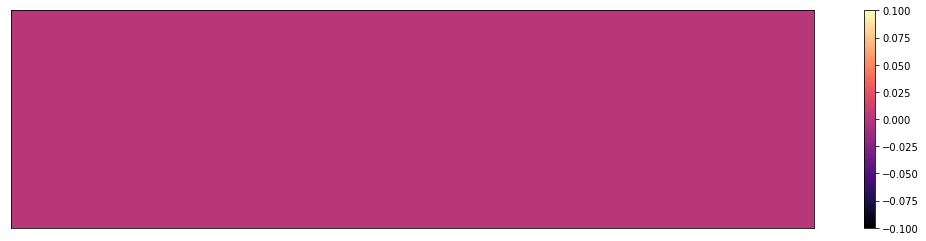

In [6]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time
import torch.distributed as dist

def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 73402
GPU = 0

model = Model()
model.cuda(GPU)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

path = get_save_path(save_dir, step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')

print('done')

plt.figure(figsize=[18, 4])
librosa.display.specshow(np.zeros([100, 100]))
plt.colorbar()
plt.show()


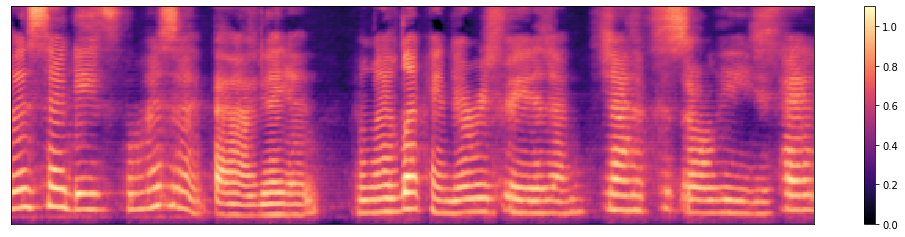

step: 73804 loss: -2.3153340816497803 elapsed time: 2.045443296432495
step: 73805 loss: -2.2971694469451904 elapsed time: 2.0777013301849365
step: 73806 loss: -2.245372772216797 elapsed time: 1.7935051918029785
step: 73807 loss: -2.25736665725708 elapsed time: 1.7382750511169434
step: 73808 loss: -2.3827743530273438 elapsed time: 2.103728771209717
step: 73809 loss: -2.3752903938293457 elapsed time: 2.105447292327881
step: 73810 loss: -2.3209476470947266 elapsed time: 1.9790172576904297
step: 73811 loss: -2.2871856689453125 elapsed time: 1.9791371822357178
step: 73812 loss: -2.408823013305664 elapsed time: 1.996206283569336
step: 73813 loss: -2.316195487976074 elapsed time: 2.0793240070343018
step: 73814 loss: -2.3849048614501953 elapsed time: 2.05772066116333
step: 73815 loss: -2.303330898284912 elapsed time: 2.0291247367858887
step: 73816 loss: -2.2941887378692627 elapsed time: 1.9527485370635986
step: 73817 loss: -2.282162666320801 elapsed time: 2.123807668685913
step: 73818 loss: -2

KeyboardInterrupt: 

In [7]:
import time

while(True):
    for i, batch in enumerate(train_loader):
        t0 = time.time()
        model.zero_grad()

        mels = batch
        mels = mels.cuda(GPU).float()
        mels = mels.unsqueeze(1)
        
        model.zero_grad()
        z, log_det = model(mels)
        
        loss = model.loss(z, log_det)
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        t1 = time.time()
        print('step:', step, 'loss:', loss.item(), 'elapsed time:', t1 - t0)
        t0 = time.time()

        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
        
        if i % 100 == 0:
            clear_output() 
            zs = [mels.data.new(1, 2, 256, 64).normal_() * 0.2,
                  mels.data.new(1, 1, 256, 64).normal_() * 0.2,
                  mels.data.new(1, 2, 128, 32).normal_() * 0.6,
                  mels.data.new(1, 1, 128, 32).normal_() * 0.6,

                  mels.data.new(1, 2, 64, 16).normal_() * 0.8,
                  mels.data.new(1, 1, 64, 16).normal_() * 0.8,
                  mels.data.new(1, 2, 32, 8).normal_() * 0.8,
                  mels.data.new(1, 1, 32, 8).normal_() * 0.8,

                  mels.data.new(1, 2, 16, 4).normal_() * 0.9,
                  mels.data.new(1, 1, 16, 4).normal_() * 0.9,
                  mels.data.new(1, 2, 8, 2).normal_() * 1.0,
                  mels.data.new(1, 1, 8, 2).normal_() * 1.0,
                  mels.data.new(1, 1, 8, 2).normal_() * 1.0]

            img_gen = model.inverse(zs)
            _img_gen = img_gen.data.cpu().numpy()
            _img_gen = np.clip(_img_gen, 0, 5)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(_img_gen[0, 0].T)
            plt.colorbar()
            plt.show()
        
        step += 1

In [8]:
path = get_save_path(save_dir, step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)

saved save/MelGlow_Conv2d1d/save_73880


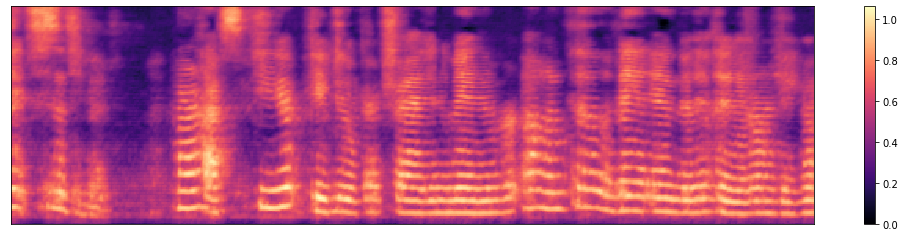

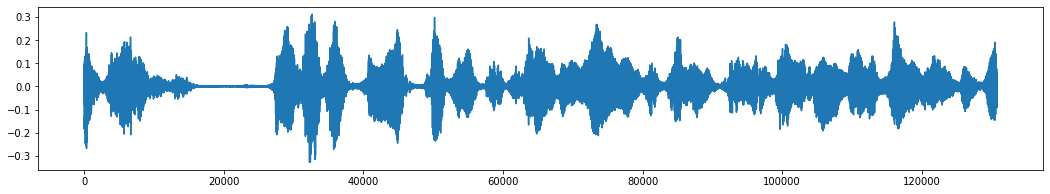

In [21]:
import scipy 

def mel_to_wave(mel):
    # mel : [T, C]
    
    def dynamic_range_decompression(y, lower_bound=1e-5):
        
        log_lower_bound = np.log(lower_bound)
        return np.exp(mel * -log_lower_bound + log_lower_bound)
    
    mel = dynamic_range_decompression(mel)
    mel_basis = librosa.filters.mel(sr=hparams.sr, n_fft=hparams.fft_length, 
                                    n_mels=hparams.n_mel, fmin=0, fmax=hparams.fmax)
    inv_basis = np.linalg.pinv(mel_basis)
    spec = inv_basis @ mel
    
    wave = librosa.core.griffinlim(spec, hop_length=hparams.hop_length)
    return wave
    
zs = [mels.data.new(1, 2, 256, 64).normal_() * 0.3,
      mels.data.new(1, 1, 256, 64).normal_() * 0.3,
      mels.data.new(1, 2, 128, 32).normal_() * 0.7,
      mels.data.new(1, 1, 128, 32).normal_() * 0.7,

      mels.data.new(1, 2, 64, 16).normal_() * 0.8,
      mels.data.new(1, 1, 64, 16).normal_() * 0.8,
      mels.data.new(1, 2, 32, 8).normal_() * 0.9,
      mels.data.new(1, 1, 32, 8).normal_() * 0.9,

      mels.data.new(1, 2, 16, 4).normal_() * 0.9,
      mels.data.new(1, 1, 16, 4).normal_() * 0.9,
      mels.data.new(1, 2, 8, 2).normal_() * 1.0,
      mels.data.new(1, 1, 8, 2).normal_() * 1.0,
      mels.data.new(1, 1, 8, 2).normal_() * 1.0]

img_gen = model.inverse(zs)
_img_gen = img_gen.data.cpu().numpy()
_img_gen = np.clip(_img_gen, 0, 2)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_img_gen[0, 0].T)
plt.colorbar()
plt.show()    

wave = mel_to_wave(_img_gen[0, 0].T)

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)